#### Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
%matplotlib inline

## Data Collection

In [ ]:
# read dataset
data = pd.read_csv("panjang_ruas_jalan_berdasarkan_kondisi_jalan_data.csv", sep = ",")

## Feature Selection

In [ ]:
data = data.drop(['nama_provinsi', 'kode_kabupaten_kota', 'kode_provinsi', 'satuan', 'nama_kabupaten_kota', 'id', 'kategori_jalan'], axis = 1)

In [ ]:
data.rename(columns={'wilayah_uptd_': 'wilayah', ' panjang_ruas_jalan ': 'panjang'}, inplace=True)
data.head(5)

,wilayah,kondisi_jalan,panjang,tahun
0,UPTD PENGELOLAAN JALAN DAN JEMBATAN WILAYAH PE...,BAIK,117.66,2018
1,UPTD PENGELOLAAN JALAN DAN JEMBATAN WILAYAH PE...,SEDANG,9.39,2018
2,UPTD PENGELOLAAN JALAN DAN JEMBATAN WILAYAH PE...,RUSAK RINGAN,5.76,2018
3,UPTD PENGELOLAAN JALAN DAN JEMBATAN WILAYAH PE...,RUSAK BERAT,NaN,2018
4,UPTD PENGELOLAAN JALAN DAN JEMBATAN WILAYAH PE...,BAIK,109.09,2018


## Exploratory Data Analysis

### Data Summary

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648 entries, 0 to 647
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   wilayah        648 non-null    object 
 1   kondisi_jalan  648 non-null    object 
 2   panjang        497 non-null    float64
 3   tahun          648 non-null    int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 20.4+ KB


In [ ]:
data.describe()

,panjang,tahun
count,497.000000,648.000000
mean,28.289437,2019.166667
std,37.679079,1.068012
min,0.060000,2018.000000
25%,3.750000,2018.000000
50%,12.860000,2019.000000
75%,40.160000,2020.000000
max,210.520000,2021.000000


In [ ]:
data["wilayah"].value_counts()

UPTD PENGELOLAAN JALAN DAN JEMBATAN WILAYAH PELAYANAN III    168
UPTD PENGELOLAAN JALAN DAN JEMBATAN WILAYAH PELAYANAN I      144
UPTD PENGELOLAAN JALAN DAN JEMBATAN WILAYAH PELAYANAN V      144
UPTD PENGELOLAAN JALAN DAN JEMBATAN WILAYAH PELAYANAN VI      96
UPTD PENGELOLAAN JALAN DAN JEMBATAN WILAYAH PELAYANAN II      48
UPTD PENGELOLAAN JALAN DAN JEMBATAN WILAYAH PELAYANAN IV      48
Name: wilayah, dtype: int64

In [ ]:
data["tahun"].value_counts()

2018    216
2019    216
2020    108
2021    108
Name: tahun, dtype: int64

In [ ]:
data["kondisi_jalan"].value_counts()

BAIK            162
SEDANG          162
RUSAK RINGAN    162
RUSAK BERAT     162
Name: kondisi_jalan, dtype: int64

### Data Visualization

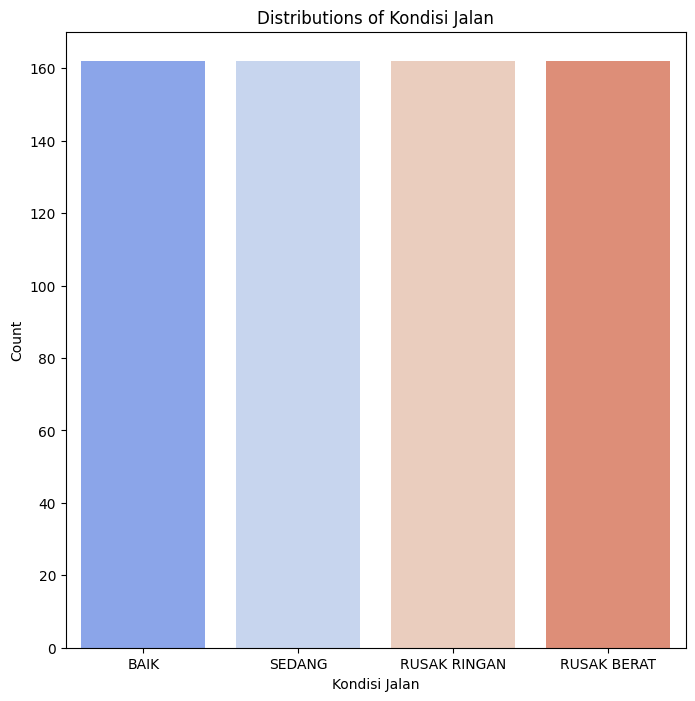

In [ ]:
plt.figure(figsize = (8, 8))
plt.title("Distributions of Kondisi Jalan")
sns.countplot(x = 'kondisi_jalan', data=data, palette = "coolwarm")
plt.ylabel("Count")
plt.xlabel("Kondisi Jalan")
plt.show()

### Data Preprocessing

##### Data Cleaning

In [ ]:
print(data.isna().sum())

wilayah            0
kondisi_jalan      0
panjang          151
tahun              0
dtype: int64


In [ ]:
data = data.dropna()

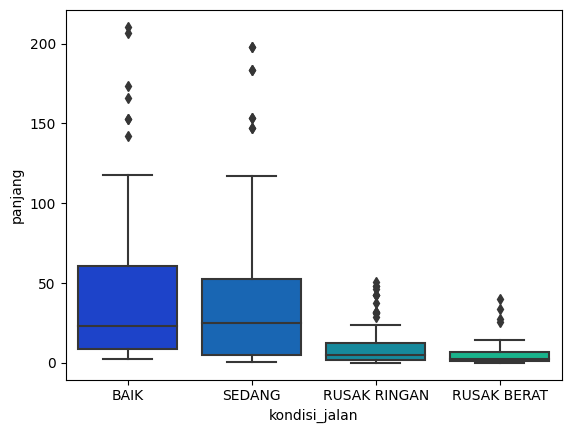

In [ ]:
# handling outliers
sns.boxplot(x='kondisi_jalan',y=data['panjang'], data=data, palette='winter')
plt.show()

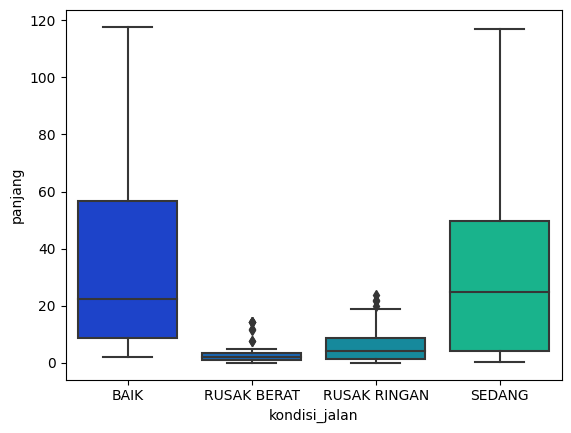

In [ ]:
grouped_data = data.groupby('kondisi_jalan')

def remove_outliers(group):
    q1 = group['panjang'].quantile(0.25)
    q3 = group['panjang'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return group[(group['panjang'] >= lower_bound) & (group['panjang'] <= upper_bound)]

filtered_data = grouped_data.apply(remove_outliers)
filtered_data = filtered_data.reset_index(drop=True)
data = filtered_data

sns.boxplot(x='kondisi_jalan', y='panjang', data=data, palette='winter')
plt.show()

##### Handling Categorical Values

In [ ]:
# Data Kondisi Jalan
data = data.replace(to_replace="BAIK",value=0)
data = data.replace(to_replace="SEDANG",value=1)
data = data.replace(to_replace="RUSAK RINGAN",value=2)
data = data.replace(to_replace="RUSAK BERAT",value=3)

In [ ]:
# Data Wilayah UPTD
data = data.replace(to_replace="UPTD PENGELOLAAN JALAN DAN JEMBATAN WILAYAH PELAYANAN I",value=0)
data = data.replace(to_replace="UPTD PENGELOLAAN JALAN DAN JEMBATAN WILAYAH PELAYANAN II",value=1)
data = data.replace(to_replace="UPTD PENGELOLAAN JALAN DAN JEMBATAN WILAYAH PELAYANAN III",value=2)
data = data.replace(to_replace="UPTD PENGELOLAAN JALAN DAN JEMBATAN WILAYAH PELAYANAN IV",value=3)
data = data.replace(to_replace="UPTD PENGELOLAAN JALAN DAN JEMBATAN WILAYAH PELAYANAN V",value=4)
data = data.replace(to_replace="UPTD PENGELOLAAN JALAN DAN JEMBATAN WILAYAH PELAYANAN VI",value=5)

##### Data Splitting

In [ ]:
# define predictor variables
x = data.drop(['kondisi_jalan'], axis=1)
x.head()

,wilayah,panjang,tahun
0,0,117.66,2018
1,1,109.09,2018
2,0,83.82,2018
3,2,54.56,2018
4,3,56.60,2018


In [ ]:
# define response variable
y = data['kondisi_jalan']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: kondisi_jalan, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25,random_state = 216)

## Uji Independensi Chi Square
uji korelasi utk variabel x & y kategorik -> uji independensi chi square / cross tabulation
tujuannya untuk cek multikolinearitas
p-value < 0.05 -> dependen/ada korelasi

In [ ]:
# tahun -> kondisi jalan
corr1 = pd.crosstab(data['tahun'], data['kondisi_jalan'])
print(corr1)

kondisi_jalan   0   1   2   3
tahun                        
2018           54  46  42   6
2019           52  46  44   6
2020           24  26  19  17
2021           25  27  18  13


In [ ]:
stats.chi2_contingency(corr1)

Chi2ContingencyResult(statistic=26.949804395163646, pvalue=0.001425759146077282, dof=9, expected_freq=array([[49.33333333, 46.15053763, 39.1483871 , 13.36774194],
       [49.33333333, 46.15053763, 39.1483871 , 13.36774194],
       [28.66666667, 26.8172043 , 22.7483871 ,  7.76774194],
       [27.66666667, 25.88172043, 21.95483871,  7.49677419]]))

In [ ]:
# wilayah -> kondisi jalan
corr2 = pd.crosstab(data['wilayah'], data['kondisi_jalan'])
print(corr2)

kondisi_jalan   0   1   2   3
wilayah                      
0              36  28  23   8
1               8  10   6  10
2              42  39  38   5
3              10   8   7   2
4              36  36  33  11
5              23  24  16   6


In [ ]:
stats.chi2_contingency(corr2)

Chi2ContingencyResult(statistic=23.989338760039573, pvalue=0.06527475382825017, dof=15, expected_freq=array([[31.66666667, 29.62365591, 25.12903226,  8.58064516],
       [11.33333333, 10.60215054,  8.99354839,  3.07096774],
       [41.33333333, 38.66666667, 32.8       , 11.2       ],
       [ 9.        ,  8.41935484,  7.14193548,  2.43870968],
       [38.66666667, 36.17204301, 30.68387097, 10.47741935],
       [23.        , 21.51612903, 18.2516129 ,  6.23225806]]))

# Uji Independensi Pearson

In [ ]:
# panjang	-> kondisi jalan
corr_coef, p_value = stats.pearsonr(data['panjang'], data['kondisi_jalan'])

print("Pearson correlation coefficient:", corr_coef)
print("p-value:", p_value)

Pearson correlation coefficient: -0.43078632645528664
p-value: 1.960856182681673e-22


# SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
svm = SVC()

In [ ]:
x_train.head()

,wilayah,panjang,tahun
60,4,38.85,2018
312,0,6.55,2021
454,2,53.66,2021
330,2,105.03,2018
224,5,2.47,2019


In [ ]:
y_train.head()

60     0
312    2
454    1
330    1
224    2
Name: kondisi_jalan, dtype: int64

In [ ]:
svm.fit(x_train,y_train)

SVC()

### Train

In [ ]:
predictions = svm.predict(x_train)

In [ ]:
print(confusion_matrix(y_train, predictions))

[[  0 105   0   0]
 [  0 111   0   0]
 [  0  98   0   0]
 [  0  34   0   0]]


In [ ]:
print(classification_report(y_train, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       105
           1       0.32      1.00      0.48       111
           2       0.00      0.00      0.00        98
           3       0.00      0.00      0.00        34

    accuracy                           0.32       348
   macro avg       0.08      0.25      0.12       348
weighted avg       0.10      0.32      0.15       348



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Test

In [ ]:
predictions = svm.predict(x_test)

In [ ]:
print(confusion_matrix(y_test, predictions))

[[ 0 50  0  0]
 [ 0 34  0  0]
 [ 0 25  0  0]
 [ 0  8  0  0]]


In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.29      1.00      0.45        34
           2       0.00      0.00      0.00        25
           3       0.00      0.00      0.00         8

    accuracy                           0.29       117
   macro avg       0.07      0.25      0.11       117
weighted avg       0.08      0.29      0.13       117



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Hyperparameter Tuning


In [ ]:
param_grid = {'C': [0.001,0.01,1,10,100,1000,10000,100000], 'gamma':[1,0.1,0.01,0.001,0.0001], 'kernel':['rbf']}

In [ ]:
grid = GridSearchCV(svm, param_grid, refit=True, verbose=1)

In [ ]:
grid.fit(x_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 1, 10, 100, 1000, 10000, 100000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=1)

In [ ]:
grid.best_estimator_

SVC(C=1000, gamma=1)

###Train

In [ ]:
grid_predictions = grid.predict(x_train)

In [ ]:
print(confusion_matrix(y_train, grid_predictions))

[[104   0   1   0]
 [  0 109   1   1]
 [  0   2  96   0]
 [  0   0   1  33]]


In [ ]:
print(classification_report(y_train, grid_predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       105
           1       0.98      0.98      0.98       111
           2       0.97      0.98      0.97        98
           3       0.97      0.97      0.97        34

    accuracy                           0.98       348
   macro avg       0.98      0.98      0.98       348
weighted avg       0.98      0.98      0.98       348



###Test

In [ ]:
grid_predictions = grid.predict(x_test)

In [ ]:
print(confusion_matrix(y_test, grid_predictions))

[[43  4  2  1]
 [ 9 17  5  3]
 [ 2  1 18  4]
 [ 0  2  0  6]]


In [ ]:
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83        50
           1       0.71      0.50      0.59        34
           2       0.72      0.72      0.72        25
           3       0.43      0.75      0.55         8

    accuracy                           0.72       117
   macro avg       0.66      0.71      0.67       117
weighted avg       0.73      0.72      0.71       117



In [ ]:
scores = cross_val_score(grid, x, y, cv=10, scoring='accuracy')

print('Accuracy per Fold:', scores)
print('Mean Accuracy:', scores.mean())

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Accuracy per Fold: [1.         0.9787234  0.9787234  0.87234043 0.93617021 0.89130435
 0.7173913  0.23913043 0.39130435 0.41304348]
Mean Accuracy: 0.7418131359851988


# K-NN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
knn.fit(x_train, y_train)

KNeighborsClassifier()

### Train

In [ ]:
yhat_train = knn.predict(x_train)

In [ ]:
cm_train = confusion_matrix(y_train, yhat_train)
cm_train

array([[83, 18,  4,  0],
       [24, 67, 14,  6],
       [22, 14, 57,  5],
       [ 5,  1,  6, 22]])

In [ ]:
print(classification_report(y_train, yhat_train))

              precision    recall  f1-score   support

           0       0.62      0.79      0.69       105
           1       0.67      0.60      0.64       111
           2       0.70      0.58      0.64        98
           3       0.67      0.65      0.66        34

    accuracy                           0.66       348
   macro avg       0.66      0.66      0.66       348
weighted avg       0.66      0.66      0.66       348



### Test

In [ ]:
yhat_test = knn.predict(x_test)

In [ ]:
cm_test = confusion_matrix(y_test, yhat_test)
cm_test

array([[32, 15,  2,  1],
       [10, 17,  5,  2],
       [ 8,  1, 12,  4],
       [ 2,  1,  1,  4]])

In [ ]:
print(classification_report(y_test, yhat_test))

              precision    recall  f1-score   support

           0       0.62      0.64      0.63        50
           1       0.50      0.50      0.50        34
           2       0.60      0.48      0.53        25
           3       0.36      0.50      0.42         8

    accuracy                           0.56       117
   macro avg       0.52      0.53      0.52       117
weighted avg       0.56      0.56      0.56       117



## Hyperparameter Tuning

In [ ]:
param_grid = {'n_neighbors':list(range(1,50))}

In [ ]:
# grid = GridSearchCV(knn, param_grid, cv=5)
grid = GridSearchCV(knn, param_grid, cv=5, refit=True, verbose=1)

In [ ]:
grid.fit(x_train, y_train)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             verbose=1)

In [ ]:
grid.best_estimator_

KNeighborsClassifier(n_neighbors=1)

### Train

In [ ]:
grid_predictions = grid.predict(x_train)

In [ ]:
print(confusion_matrix(y_train, grid_predictions))

[[105   0   0   0]
 [  0 110   0   1]
 [  0   0  97   1]
 [  0   0   0  34]]


In [ ]:
print(classification_report(y_train, grid_predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       1.00      0.99      1.00       111
           2       1.00      0.99      0.99        98
           3       0.94      1.00      0.97        34

    accuracy                           0.99       348
   macro avg       0.99      1.00      0.99       348
weighted avg       0.99      0.99      0.99       348



### Test

In [ ]:
grid_predictions = grid.predict(x_test)

In [ ]:
print(confusion_matrix(y_test, grid_predictions))

[[36 11  2  1]
 [ 5 21  4  4]
 [ 3  2 16  4]
 [ 0  2  0  6]]


In [ ]:
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.82      0.72      0.77        50
           1       0.58      0.62      0.60        34
           2       0.73      0.64      0.68        25
           3       0.40      0.75      0.52         8

    accuracy                           0.68       117
   macro avg       0.63      0.68      0.64       117
weighted avg       0.70      0.68      0.68       117



In [ ]:
scores = cross_val_score(grid, x, y, cv=10, scoring='accuracy')

print('Accuracy per Fold:', scores)
print('Mean Accuracy:', scores.mean())

Fitting 5 folds for each of 49 candidates, totalling 245 fits
Fitting 5 folds for each of 49 candidates, totalling 245 fits
Fitting 5 folds for each of 49 candidates, totalling 245 fits
Fitting 5 folds for each of 49 candidates, totalling 245 fits
Fitting 5 folds for each of 49 candidates, totalling 245 fits
Fitting 5 folds for each of 49 candidates, totalling 245 fits
Fitting 5 folds for each of 49 candidates, totalling 245 fits
Fitting 5 folds for each of 49 candidates, totalling 245 fits
Fitting 5 folds for each of 49 candidates, totalling 245 fits
Fitting 5 folds for each of 49 candidates, totalling 245 fits
Accuracy per Fold: [1.         1.         1.         0.91489362 0.9787234  0.93478261
 0.67391304 0.2826087  0.36956522 0.39130435]
Mean Accuracy: 0.7545790934320075
